In [1]:
# modified 'Evaluation script for the EndoVis / CATARACTS 2020 challenge.'

import os
import glob
import numpy as np
from argparse import ArgumentParser
from pandas import read_csv
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score, precision_score,accuracy_score
from matplotlib import pyplot as plt

In [2]:
from sklearn import metrics
import numpy as np
import pickle
import shutil
import os

In [3]:
from matplotlib import cm

In [4]:
# 'Idle',
steps = ['Toric Marking', 'Implant Ejection', 'Incision', 'Viscodilatation', 'Capsulorhexis', 'Hydrodissetion',
         'Nucleus Breaking', 'Phacoemulsification', 'Vitrectomy', 'Irrigation/Aspiration', 'Preparing Implant',
         'Manual Aspiration', 'Implantation', 'Positioning', 'OVD Aspiration', 'Suturing', 'Sealing Control',
         'Wound Hydratation']

In [5]:
def fix_outliers(truth_data_steps, prediction_data_steps):

    steps_order = [truth_data_steps[0]]
    for step_index in range(len(truth_data_steps)):
        if step_index != 0 and truth_data_steps[step_index] != truth_data_steps[step_index-1]:
            steps_order.append(truth_data_steps[step_index])

    k = 0
    for i in range(len(truth_data_steps)):

        if i !=0 and truth_data_steps[i] != truth_data_steps[i-1]:
            k = k + 1

        if truth_data_steps[i] == 0: # check for idle step
            if truth_data_steps[i] != prediction_data_steps[i]:
                list_values_to_check = [steps_order[k], steps_order[k+1]] if k==0 else ([steps_order[k-1],
                                                                                         steps_order[k]] if k==len(steps_order)-1 else
                                                                                        [steps_order[k-1],
                                                                                         steps_order[k],
                                                                                        steps_order[k + 1]])
                if prediction_data_steps[i] in list_values_to_check:
                    prediction_data_steps[i] = truth_data_steps[i]


    return truth_data_steps, prediction_data_steps

In [79]:
def change_video_order(f1_scores):
    pos = [24,13,3,1,23,10,22,20,0,17,4,2,21,18,11,15,19,9,6,16,12,8,5,7,14 ]
    f1_scores_pos = np.zeros(25)
    for i in range(25):
        f1_scores_pos[i] = f1_scores[pos[i]]
            
    return f1_scores_pos

# plot f1 scores of 25 videos
def plot_f1_scores(f1_scores_pos,model):
    v = np.arange(1, len(f1_scores_pos)+1,1)
    plt.figure()
    # plt.plot(v,f1_scores ,'b')
    #plt.scatter(v,f1_scores, alpha = 0.5)

    plt.bar(v,f1_scores_pos, alpha = 0.5)

    plt.title("The f1-scores of 25 test videos of " + model)
    plt.xlabel('test videos')
    plt.ylabel('f1-score')
    plt.grid()


In [81]:
# evalueate function from Challenge 2020: f1-score
# yilin adds accuracy precision recall
def compute_f1score(gt,predictions):
    """
    Main function.
    """
    # parsing the command line
#     parser = ArgumentParser(
#         description = 'Evaluation script for the EndoVis / CATARACTS 2020 challenge.')
#     parser.add_argument('-t', '--gt', required = True,
#                         help = 'directory containing ground truth files')
#     parser.add_argument('-p', '--predictions',required = True,
#                         help = 'directory containing automatic predictions')

    num_steps = len(steps) + 1  #19

#     gt = './non-local-only/gt-phase/'
#     predictions = './non-local-only/pred-phase/'
    
    list_truth_files = glob.glob(os.path.join(gt, "*.csv"))   # csv args.gt
    
    assert len(list_truth_files) > 0, "No ground truth files were found!!"

    f1_scores = []
    accuracy = []
    precision = []
    recall = []
    try:
        for file in list_truth_files:
            file_name = os.path.basename(file)
            # yilin add
            
            if os.path.exists(predictions + '/' + os.path.basename(file)):
                truth_filename = os.path.join(gt, file_name)
                prediction_filename = os.path.join(predictions, file_name)

                # parsing the right columns for the current tool
                truth_data = read_csv(truth_filename, header=None, skipinitialspace=True, squeeze=True, dtype='Int64')
                prediction_data = read_csv(prediction_filename, header=None, skipinitialspace=True, squeeze=True, dtype='Int64')

                if len(truth_data) != len(prediction_data):
                    raise ValueError('Files {} and {} have different row counts'.
                                     format(truth_filename, prediction_filename))

                truth_data_steps = truth_data.iloc[:, 1].tolist() # ["Steps"]
                prediction_data_steps = prediction_data.iloc[:, 1].tolist()

                # We don't take into account the idle frames
                #idle_frames = list(filter(lambda x: truth_data_steps[x] == 0, range(len(truth_data_steps))))

                # To reduce the impact of the idle step on the results.
                truth_data_steps, prediction_data_steps = fix_outliers(truth_data_steps, prediction_data_steps)
                
                # np.array(truth_data_steps) =
                
                accuracy_video = np.sum(np.array(truth_data_steps) == np.array(prediction_data_steps))/len(truth_data_steps)
                
                truth_data_steps = np.eye(num_steps)[truth_data_steps]
                prediction_data_steps = np.eye(num_steps)[prediction_data_steps]

                # Remove idle frames
                # truth_data_steps = np.delete(truth_data_steps, idle_frames,0)
                # prediction_data_steps = np.delete(prediction_data_steps, idle_frames, 0)

                # Removing the idle class from the evaluation
                truth_data_steps = truth_data_steps[:,1:]
                prediction_data_steps = prediction_data_steps[:, 1:]

                steps_f1_score = []
                steps_accuracy = []
                steps_precision = []
                steps_recall = []
                ind = 0
                for step_gt, step_prediction in zip(truth_data_steps.T, prediction_data_steps.T):
                    count_nonzero = np.count_nonzero(step_gt)
                    if count_nonzero != 0:
                        f1_score_step = f1_score(step_gt, step_prediction, average='binary') # 'binary'
                        
                        # 'binary'
                        # print(str(ind + 1) + ' ' + steps[ind] + ' ' + "{:.4f}".format(f1_score_step))
                        
                        precision_step = precision_score(step_gt, step_prediction, average='macro') # , average='macro'
                        recall_step = recall_score(step_gt, step_prediction, average='macro')

                        
#                         accuracy_step = accuracy_score(step_gt, step_prediction)
#                         precision_step = precision_score(step_gt, step_prediction, average='macro')
#                         recall_step = recall_score(step_gt, step_prediction, average='macro')
                        #average='binary'
                        
                        steps_f1_score.append(f1_score_step)
                        #steps_accuracy.append(accuracy_step)
                        steps_precision.append(precision_step)
                        steps_recall.append(recall_step)
                        
                    ind = ind + 1

                # computing video-specific scores
                f1_score_video = np.mean(steps_f1_score)
                #accuracy_video = np.mean(steps_accuracy)
                precision_video = np.mean(steps_precision)
                recall_video = np.mean(steps_recall)
                
                f1_scores.append(f1_score_video)
                accuracy.append(accuracy_video)
                precision.append(precision_video)
                recall.append(recall_video)
                
                print("f1-score of "+file_name + ' : ' + "{:.4f}".format(f1_score_video))
                print("accuracy of "+file_name + ' : ' + "{:.4f}".format(accuracy_video))
                print("precision of "+file_name + ' : ' + "{:.4f}".format(precision_video))
                print("recall of "+file_name + ' : ' + "{:.4f} \n".format(recall_video))
                
                

            else:
                raise ValueError(file_name + ' could not be found in the predictions folder.')


    except Exception as e:
        print('Error: {} -> {}.'.format(file_name, e))
        f1_scores = []

    # computing the average score
    print('** Average f1-score: ' + "{:.4f}".format(np.mean(f1_scores)))
    print('** std f1-score: ' + "{:.4f}".format(np.std(f1_scores)))
    print('** Average accuracy: ' + "{:.4f}".format(np.mean(accuracy)))
    print('** std accuracy: ' + "{:.4f}".format(np.std(accuracy)))
    print('** Average precision: ' + "{:.4f}".format(np.mean(precision)))
    print('** std precision: ' + "{:.4f}".format(np.std(precision)))
    print('** Average recall: ' + "{:.4f}".format(np.mean(recall)))
    print('** std recall: ' + "{:.4f}".format(np.std(recall)))
    
    #return f1_scores
    return f1_scores,accuracy,precision,recall

In [ ]:
# pos = [24,13,3,1,23,10,22,20,0,17,4,2,21,18,11,15,19,9,6,16,12,8,5,7,14 ]
# f1_scores_pos = np.zeros(25)
# delete video 1,7,14,16,19 for computing the results of 20 test videos
1,7,14,16,19

24,22,18,15,6

In [84]:
# compute the results of 20 test videos
def f1_acc_20(f1_scores,accuracy,precision,recall):
    ind = [24,22,18,15,6]
    for i in ind:
        del f1_scores[i]
        del accuracy[i]
        del precision[i]
        del recall[i]
    
    print('** Average f1-score: ' + "{:.4f}".format(np.mean(f1_scores)))
    print('** std f1-score: ' + "{:.4f}".format(np.std(f1_scores)))
    print('** Average accuracy: ' + "{:.4f}".format(np.mean(accuracy)))
    print('** std accuracy: ' + "{:.4f}".format(np.std(accuracy)))
    print('** Average precision: ' + "{:.4f}".format(np.mean(precision)))
    print('** std precision: ' + "{:.4f}".format(np.std(precision)))
    print('** Average recall: ' + "{:.4f}".format(np.mean(recall)))
    print('** std recall: ' + "{:.4f}".format(np.std(recall)))

# Compute f1-score, accuracy, precision, recall of 25 videos/ 20 videos respectively

In [82]:
f1_scores_m1,accuracy_m1,precision_m1,recall_m1 = compute_f1score(gt = './M1/gt-step-resnet',\
                predictions = './M1/pred-step-resnet')

f1-score of video9-phase.csv : 0.8212
accuracy of video9-phase.csv : 0.8326
precision of video9-phase.csv : 0.9217
recall of video9-phase.csv : 0.9235 

f1-score of video4-phase.csv : 0.9240
accuracy of video4-phase.csv : 0.9255
precision of video4-phase.csv : 0.9759
recall of video4-phase.csv : 0.9507 

f1-score of video12-phase.csv : 0.9146
accuracy of video12-phase.csv : 0.9258
precision of video12-phase.csv : 0.9806
recall of video12-phase.csv : 0.9395 

f1-score of video3-phase.csv : 0.9600
accuracy of video3-phase.csv : 0.9682
precision of video3-phase.csv : 0.9964
recall of video3-phase.csv : 0.9648 

f1-score of video11-phase.csv : 0.7765
accuracy of video11-phase.csv : 0.8541
precision of video11-phase.csv : 0.8894
recall of video11-phase.csv : 0.8845 

f1-score of video23-phase.csv : 0.8659
accuracy of video23-phase.csv : 0.8908
precision of video23-phase.csv : 0.9452
recall of video23-phase.csv : 0.9192 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video19-phase.csv : 0.5282
accuracy of video19-phase.csv : 0.6352
precision of video19-phase.csv : 0.7764
recall of video19-phase.csv : 0.7619 

f1-score of video24-phase.csv : 0.9219
accuracy of video24-phase.csv : 0.9264
precision of video24-phase.csv : 0.9815
recall of video24-phase.csv : 0.9441 

f1-score of video22-phase.csv : 0.8301
accuracy of video22-phase.csv : 0.8499
precision of video22-phase.csv : 0.9545
recall of video22-phase.csv : 0.9032 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video18-phase.csv : 0.7479
accuracy of video18-phase.csv : 0.7997
precision of video18-phase.csv : 0.8798
recall of video18-phase.csv : 0.8692 

f1-score of video6-phase.csv : 0.7980
accuracy of video6-phase.csv : 0.8885
precision of video6-phase.csv : 0.9165
recall of video6-phase.csv : 0.8954 

f1-score of video15-phase.csv : 0.8697
accuracy of video15-phase.csv : 0.8719
precision of video15-phase.csv : 0.9511
recall of video15-phase.csv : 0.9254 

f1-score of video21-phase.csv : 0.7328
accuracy of video21-phase.csv : 0.7979
precision of video21-phase.csv : 0.9209
recall of video21-phase.csv : 0.8548 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video2-phase.csv : 0.3009
accuracy of video2-phase.csv : 0.4798
precision of video2-phase.csv : 0.6856
recall of video2-phase.csv : 0.6280 

f1-score of video25-phase.csv : 0.8934
accuracy of video25-phase.csv : 0.8949
precision of video25-phase.csv : 0.9556
recall of video25-phase.csv : 0.9344 

f1-score of video16-phase.csv : 0.8061
accuracy of video16-phase.csv : 0.8475
precision of video16-phase.csv : 0.9370
recall of video16-phase.csv : 0.8949 

f1-score of video20-phase.csv : 0.8543
accuracy of video20-phase.csv : 0.8764
precision of video20-phase.csv : 0.9261
recall of video20-phase.csv : 0.9364 

f1-score of video10-phase.csv : 0.9065
accuracy of video10-phase.csv : 0.8556
precision of video10-phase.csv : 0.9773
recall of video10-phase.csv : 0.9357 

f1-score of video14-phase.csv : 0.7641
accuracy of video14-phase.csv : 0.9010
precision of video14-phase.csv : 0.9127
recall of video14-phase.csv : 0.8752 

f1-score of video17-phase.csv : 0.7763
accuracy of video17-pha

/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video7-phase.csv : 0.5556
accuracy of video7-phase.csv : 0.6192
precision of video7-phase.csv : 0.8086
recall of video7-phase.csv : 0.7745 

f1-score of video5-phase.csv : 0.9642
accuracy of video5-phase.csv : 0.9680
precision of video5-phase.csv : 0.9890
recall of video5-phase.csv : 0.9748 

f1-score of video1-phase.csv : 0.5209
accuracy of video1-phase.csv : 0.6141
precision of video1-phase.csv : 0.8761
recall of video1-phase.csv : 0.7669 

** Average f1-score: 0.7850
** std f1-score: 0.1550
** Average accuracy: 0.8288
** std accuracy: 0.1196
** Average precision: 0.9160
** std precision: 0.0698
** Average recall: 0.8846
** std recall: 0.0770


In [85]:
f1_acc_20(f1_scores_m1,accuracy_m1,precision_m1,recall_m1)

** Average f1-score: 0.8225
** std f1-score: 0.1384
** Average accuracy: 0.8551
** std accuracy: 0.1027
** Average precision: 0.9295
** std precision: 0.0653
** Average recall: 0.9021
** std recall: 0.0710


In [86]:
f1_scores_m2,accuracy_m2,precision_m2,recall_m2 = compute_f1score(gt = './M2/gt-step-resnet',\
                predictions = './M2/pred-step-resnet')

f1-score of video9-phase.csv : 0.7003
accuracy of video9-phase.csv : 0.7411
precision of video9-phase.csv : 0.8699
recall of video9-phase.csv : 0.8662 

f1-score of video4-phase.csv : 0.9062
accuracy of video4-phase.csv : 0.9089
precision of video4-phase.csv : 0.9734
recall of video4-phase.csv : 0.9423 

f1-score of video12-phase.csv : 0.8929
accuracy of video12-phase.csv : 0.9386
precision of video12-phase.csv : 0.9812
recall of video12-phase.csv : 0.9320 

f1-score of video3-phase.csv : 0.9401
accuracy of video3-phase.csv : 0.9463
precision of video3-phase.csv : 0.9794
recall of video3-phase.csv : 0.9606 

f1-score of video11-phase.csv : 0.7872
accuracy of video11-phase.csv : 0.8521
precision of video11-phase.csv : 0.9417
recall of video11-phase.csv : 0.8767 

f1-score of video23-phase.csv : 0.8616
accuracy of video23-phase.csv : 0.8544
precision of video23-phase.csv : 0.9476
recall of video23-phase.csv : 0.9121 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video19-phase.csv : 0.4833
accuracy of video19-phase.csv : 0.5765
precision of video19-phase.csv : 0.7730
recall of video19-phase.csv : 0.7494 

f1-score of video24-phase.csv : 0.8282
accuracy of video24-phase.csv : 0.8779
precision of video24-phase.csv : 0.9339
recall of video24-phase.csv : 0.9157 

f1-score of video22-phase.csv : 0.8655
accuracy of video22-phase.csv : 0.8418
precision of video22-phase.csv : 0.9631
recall of video22-phase.csv : 0.9200 

f1-score of video18-phase.csv : 0.7950
accuracy of video18-phase.csv : 0.8040
precision of video18-phase.csv : 0.9226
recall of video18-phase.csv : 0.8986 

f1-score of video6-phase.csv : 0.7499
accuracy of video6-phase.csv : 0.8372
precision of video6-phase.csv : 0.8786
recall of video6-phase.csv : 0.8888 

f1-score of video15-phase.csv : 0.8329
accuracy of video15-phase.csv : 0.8471
precision of video15-phase.csv : 0.9585
recall of video15-phase.csv : 0.9026 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video21-phase.csv : 0.6143
accuracy of video21-phase.csv : 0.7042
precision of video21-phase.csv : 0.8703
recall of video21-phase.csv : 0.8153 

f1-score of video2-phase.csv : 0.3045
accuracy of video2-phase.csv : 0.4356
precision of video2-phase.csv : 0.6896
recall of video2-phase.csv : 0.6424 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video25-phase.csv : 0.8327
accuracy of video25-phase.csv : 0.8339
precision of video25-phase.csv : 0.9261
recall of video25-phase.csv : 0.9018 

f1-score of video16-phase.csv : 0.8428
accuracy of video16-phase.csv : 0.8548
precision of video16-phase.csv : 0.9341
recall of video16-phase.csv : 0.9178 

f1-score of video20-phase.csv : 0.7252
accuracy of video20-phase.csv : 0.8296
precision of video20-phase.csv : 0.9168
recall of video20-phase.csv : 0.8767 

f1-score of video10-phase.csv : 0.8423
accuracy of video10-phase.csv : 0.8327
precision of video10-phase.csv : 0.9495
recall of video10-phase.csv : 0.9094 

f1-score of video14-phase.csv : 0.6956
accuracy of video14-phase.csv : 0.8198
precision of video14-phase.csv : 0.8915
recall of video14-phase.csv : 0.8507 

f1-score of video17-phase.csv : 0.8828
accuracy of video17-phase.csv : 0.8728
precision of video17-phase.csv : 0.9691
recall of video17-phase.csv : 0.9267 

f1-score of video8-phase.csv : 0.8290
accuracy of video8-p

/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video7-phase.csv : 0.4729
accuracy of video7-phase.csv : 0.5933
precision of video7-phase.csv : 0.7566
recall of video7-phase.csv : 0.7531 

f1-score of video5-phase.csv : 0.9489
accuracy of video5-phase.csv : 0.9318
precision of video5-phase.csv : 0.9873
recall of video5-phase.csv : 0.9615 

f1-score of video1-phase.csv : 0.4301
accuracy of video1-phase.csv : 0.6313
precision of video1-phase.csv : 0.7201
recall of video1-phase.csv : 0.7440 

** Average f1-score: 0.7553
** std f1-score: 0.1659
** Average accuracy: 0.8040
** std accuracy: 0.1228
** Average precision: 0.9032
** std precision: 0.0812
** Average recall: 0.8748
** std recall: 0.0757


/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
f1_acc_20(f1_scores_m2,accuracy_m2,precision_m2,recall_m2)

** Average f1-score: 0.7979
** std f1-score: 0.1380
** Average accuracy: 0.8312
** std accuracy: 0.1081
** Average precision: 0.9252
** std precision: 0.0641
** Average recall: 0.8928
** std recall: 0.0659


In [88]:
f1_scores_m3,accuracy_m3,precision_m3,recall_m3 = compute_f1score(gt = './M3/gt-step-resnet',\
                predictions = './M3/pred-step-resnet')

f1-score of video9-phase.csv : 0.8136
accuracy of video9-phase.csv : 0.8465
precision of video9-phase.csv : 0.9180
recall of video9-phase.csv : 0.9264 

f1-score of video4-phase.csv : 0.9221
accuracy of video4-phase.csv : 0.9027
precision of video4-phase.csv : 0.9780
recall of video4-phase.csv : 0.9561 

f1-score of video12-phase.csv : 0.8866
accuracy of video12-phase.csv : 0.9386
precision of video12-phase.csv : 0.9840
recall of video12-phase.csv : 0.9226 

f1-score of video3-phase.csv : 0.9084
accuracy of video3-phase.csv : 0.9264
precision of video3-phase.csv : 0.9757
recall of video3-phase.csv : 0.9364 

f1-score of video11-phase.csv : 0.8436
accuracy of video11-phase.csv : 0.8658
precision of video11-phase.csv : 0.9667
recall of video11-phase.csv : 0.8924 

f1-score of video23-phase.csv : 0.8255
accuracy of video23-phase.csv : 0.8161
precision of video23-phase.csv : 0.9357
recall of video23-phase.csv : 0.8979 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video19-phase.csv : 0.4184
accuracy of video19-phase.csv : 0.3880
precision of video19-phase.csv : 0.7617
recall of video19-phase.csv : 0.7033 

f1-score of video24-phase.csv : 0.8780
accuracy of video24-phase.csv : 0.9205
precision of video24-phase.csv : 0.9566
recall of video24-phase.csv : 0.9305 

f1-score of video22-phase.csv : 0.8593
accuracy of video22-phase.csv : 0.8600
precision of video22-phase.csv : 0.9873
recall of video22-phase.csv : 0.9033 

f1-score of video18-phase.csv : 0.8061
accuracy of video18-phase.csv : 0.8312
precision of video18-phase.csv : 0.9250
recall of video18-phase.csv : 0.9068 

f1-score of video6-phase.csv : 0.8503
accuracy of video6-phase.csv : 0.9327
precision of video6-phase.csv : 0.9351
recall of video6-phase.csv : 0.9227 

f1-score of video15-phase.csv : 0.8259
accuracy of video15-phase.csv : 0.8368
precision of video15-phase.csv : 0.9509
recall of video15-phase.csv : 0.9122 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video21-phase.csv : 0.6456
accuracy of video21-phase.csv : 0.7542
precision of video21-phase.csv : 0.8761
recall of video21-phase.csv : 0.8379 

f1-score of video2-phase.csv : 0.2466
accuracy of video2-phase.csv : 0.4496
precision of video2-phase.csv : 0.7239
recall of video2-phase.csv : 0.6123 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video25-phase.csv : 0.9220
accuracy of video25-phase.csv : 0.9237
precision of video25-phase.csv : 0.9665
recall of video25-phase.csv : 0.9543 

f1-score of video16-phase.csv : 0.8353
accuracy of video16-phase.csv : 0.8372
precision of video16-phase.csv : 0.9340
recall of video16-phase.csv : 0.9184 

f1-score of video20-phase.csv : 0.6826
accuracy of video20-phase.csv : 0.7809
precision of video20-phase.csv : 0.8742
recall of video20-phase.csv : 0.8432 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video10-phase.csv : 0.8477
accuracy of video10-phase.csv : 0.8398
precision of video10-phase.csv : 0.9447
recall of video10-phase.csv : 0.9222 

f1-score of video14-phase.csv : 0.7118
accuracy of video14-phase.csv : 0.8985
precision of video14-phase.csv : 0.8598
recall of video14-phase.csv : 0.8642 

f1-score of video17-phase.csv : 0.8510
accuracy of video17-phase.csv : 0.8845
precision of video17-phase.csv : 0.9518
recall of video17-phase.csv : 0.9214 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib

f1-score of video8-phase.csv : 0.8539
accuracy of video8-phase.csv : 0.9255
precision of video8-phase.csv : 0.9423
recall of video8-phase.csv : 0.9139 

f1-score of video13-phase.csv : 0.8569
accuracy of video13-phase.csv : 0.8777
precision of video13-phase.csv : 0.9364
recall of video13-phase.csv : 0.9202 

f1-score of video7-phase.csv : 0.5402
accuracy of video7-phase.csv : 0.6308
precision of video7-phase.csv : 0.8049
recall of video7-phase.csv : 0.7645 

f1-score of video5-phase.csv : 0.9198
accuracy of video5-phase.csv : 0.9275
precision of video5-phase.csv : 0.9787
recall of video5-phase.csv : 0.9461 

f1-score of video1-phase.csv : 0.4230
accuracy of video1-phase.csv : 0.5676
precision of video1-phase.csv : 0.7558
recall of video1-phase.csv : 0.7314 

** Average f1-score: 0.7670
** std f1-score: 0.1756
** Average accuracy: 0.8145
** std accuracy: 0.1464
** Average precision: 0.9130
** std precision: 0.0744
** Average recall: 0.8784
** std recall: 0.0847


/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
f1_acc_20(f1_scores_m3,accuracy_m3,precision_m3,recall_m3)

** Average f1-score: 0.8123
** std f1-score: 0.1468
** Average accuracy: 0.8520
** std accuracy: 0.1058
** Average precision: 0.9354
** std precision: 0.0574
** Average recall: 0.8989
** std recall: 0.0721


In [90]:
f1_scores_m4,accuracy_m4,precision_m4,recall_m4 = compute_f1score(gt = './M4/gt-step-resnet',\
                predictions = './M4/pred-step-resnet')

f1-score of video9-phase.csv : 0.8004
accuracy of video9-phase.csv : 0.8202
precision of video9-phase.csv : 0.9154
recall of video9-phase.csv : 0.9140 

f1-score of video4-phase.csv : 0.9051
accuracy of video4-phase.csv : 0.9068
precision of video4-phase.csv : 0.9854
recall of video4-phase.csv : 0.9292 

f1-score of video12-phase.csv : 0.9407
accuracy of video12-phase.csv : 0.9514
precision of video12-phase.csv : 0.9928
recall of video12-phase.csv : 0.9505 

f1-score of video3-phase.csv : 0.9560
accuracy of video3-phase.csv : 0.9642
precision of video3-phase.csv : 0.9962
recall of video3-phase.csv : 0.9608 

f1-score of video11-phase.csv : 0.7322
accuracy of video11-phase.csv : 0.8288
precision of video11-phase.csv : 0.9472
recall of video11-phase.csv : 0.8447 

f1-score of video23-phase.csv : 0.8981
accuracy of video23-phase.csv : 0.8985
precision of video23-phase.csv : 0.9658
recall of video23-phase.csv : 0.9326 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video19-phase.csv : 0.5202
accuracy of video19-phase.csv : 0.5779
precision of video19-phase.csv : 0.8042
recall of video19-phase.csv : 0.7592 

f1-score of video24-phase.csv : 0.9467
accuracy of video24-phase.csv : 0.9593
precision of video24-phase.csv : 0.9902
recall of video24-phase.csv : 0.9626 

f1-score of video22-phase.csv : 0.8406
accuracy of video22-phase.csv : 0.8641
precision of video22-phase.csv : 0.9692
recall of video22-phase.csv : 0.9032 

f1-score of video18-phase.csv : 0.8202
accuracy of video18-phase.csv : 0.8212
precision of video18-phase.csv : 0.9429
recall of video18-phase.csv : 0.8930 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video6-phase.csv : 0.8066
accuracy of video6-phase.csv : 0.9027
precision of video6-phase.csv : 0.9302
recall of video6-phase.csv : 0.8912 

f1-score of video15-phase.csv : 0.8896
accuracy of video15-phase.csv : 0.8781
precision of video15-phase.csv : 0.9776
recall of video15-phase.csv : 0.9333 

f1-score of video21-phase.csv : 0.7407
accuracy of video21-phase.csv : 0.8104
precision of video21-phase.csv : 0.9221
recall of video21-phase.csv : 0.8548 

f1-score of video2-phase.csv : 0.3642
accuracy of video2-phase.csv : 0.5024
precision of video2-phase.csv : 0.7453
recall of video2-phase.csv : 0.6591 

f1-score of video25-phase.csv : 0.8957
accuracy of video25-phase.csv : 0.9017
precision of video25-phase.csv : 0.9621
recall of video25-phase.csv : 0.9318 

f1-score of video16-phase.csv : 0.8036
accuracy of video16-phase.csv : 0.8270
precision of video16-phase.csv : 0.9341
recall of video16-phase.csv : 0.8959 

f1-score of video20-phase.csv : 0.8212
accuracy of video20-phase.c

/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib

f1-score of video17-phase.csv : 0.8415
accuracy of video17-phase.csv : 0.8650
precision of video17-phase.csv : 0.9557
recall of video17-phase.csv : 0.8975 

f1-score of video8-phase.csv : 0.8728
accuracy of video8-phase.csv : 0.9413
precision of video8-phase.csv : 0.9471
recall of video8-phase.csv : 0.9243 

f1-score of video13-phase.csv : 0.7815
accuracy of video13-phase.csv : 0.7860
precision of video13-phase.csv : 0.9134
recall of video13-phase.csv : 0.8850 

f1-score of video7-phase.csv : 0.5398
accuracy of video7-phase.csv : 0.6385
precision of video7-phase.csv : 0.8038
recall of video7-phase.csv : 0.7609 

f1-score of video5-phase.csv : 0.9745
accuracy of video5-phase.csv : 0.9787
precision of video5-phase.csv : 0.9906
recall of video5-phase.csv : 0.9836 

f1-score of video1-phase.csv : 0.3825
accuracy of video1-phase.csv : 0.5504
precision of video1-phase.csv : 0.8743
recall of video1-phase.csv : 0.7112 

** Average f1-score: 0.7877
** std f1-score: 0.1630
** Average accuracy: 0

/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
f1_acc_20(f1_scores_m4,accuracy_m4,precision_m4,recall_m4)

** Average f1-score: 0.8346
** std f1-score: 0.1269
** Average accuracy: 0.8640
** std accuracy: 0.0998
** Average precision: 0.9471
** std precision: 0.0532
** Average recall: 0.9039
** std recall: 0.0654


In [92]:
f1_scores_m5,accuracy_m5,precision_m5,recall_m5 = compute_f1score(gt = './M5/gt-step-resnet',\
                predictions = './M5/pred-step-resnet')

f1-score of video9-phase.csv : 0.7542
accuracy of video9-phase.csv : 0.8233
precision of video9-phase.csv : 0.8811
recall of video9-phase.csv : 0.9013 

f1-score of video4-phase.csv : 0.9009
accuracy of video4-phase.csv : 0.9275
precision of video4-phase.csv : 0.9703
recall of video4-phase.csv : 0.9461 

f1-score of video12-phase.csv : 0.8994
accuracy of video12-phase.csv : 0.9412
precision of video12-phase.csv : 0.9818
recall of video12-phase.csv : 0.9358 

f1-score of video3-phase.csv : 0.9643
accuracy of video3-phase.csv : 0.9702
precision of video3-phase.csv : 0.9939
recall of video3-phase.csv : 0.9712 

f1-score of video11-phase.csv : 0.8428
accuracy of video11-phase.csv : 0.8696
precision of video11-phase.csv : 0.9595
recall of video11-phase.csv : 0.9031 

f1-score of video23-phase.csv : 0.8574
accuracy of video23-phase.csv : 0.8889
precision of video23-phase.csv : 0.9465
recall of video23-phase.csv : 0.9187 

f1-score of video19-phase.csv : 0.4482
accuracy of video19-phase.csv :

/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video6-phase.csv : 0.7947
accuracy of video6-phase.csv : 0.9027
precision of video6-phase.csv : 0.9186
recall of video6-phase.csv : 0.8951 

f1-score of video15-phase.csv : 0.8128
accuracy of video15-phase.csv : 0.8450
precision of video15-phase.csv : 0.9611
recall of video15-phase.csv : 0.8904 

f1-score of video21-phase.csv : 0.6601
accuracy of video21-phase.csv : 0.7729
precision of video21-phase.csv : 0.8679
recall of video21-phase.csv : 0.8373 

f1-score of video2-phase.csv : 0.2924
accuracy of video2-phase.csv : 0.4550
precision of video2-phase.csv : 0.7059
recall of video2-phase.csv : 0.6368 

f1-score of video25-phase.csv : 0.8968
accuracy of video25-phase.csv : 0.8898
precision of video25-phase.csv : 0.9559
recall of video25-phase.csv : 0.9374 

f1-score of video16-phase.csv : 0.8772
accuracy of video16-phase.csv : 0.8856
precision of video16-phase.csv : 0.9471
recall of video16-phase.csv : 0.9348 

f1-score of video20-phase.csv : 0.7329
accuracy of video20-phase.c

/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video13-phase.csv : 0.8385
accuracy of video13-phase.csv : 0.7950
precision of video13-phase.csv : 0.9263
recall of video13-phase.csv : 0.9109 

f1-score of video7-phase.csv : 0.4566
accuracy of video7-phase.csv : 0.5769
precision of video7-phase.csv : 0.7953
recall of video7-phase.csv : 0.7130 

f1-score of video5-phase.csv : 0.9781
accuracy of video5-phase.csv : 0.9680
precision of video5-phase.csv : 0.9956
recall of video5-phase.csv : 0.9817 

f1-score of video1-phase.csv : 0.4284
accuracy of video1-phase.csv : 0.6127
precision of video1-phase.csv : 0.6978
recall of video1-phase.csv : 0.7321 

** Average f1-score: 0.7731
** std f1-score: 0.1748
** Average accuracy: 0.8240
** std accuracy: 0.1350
** Average precision: 0.9109
** std precision: 0.0813
** Average recall: 0.8823
** std recall: 0.0849


/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
f1_acc_20(f1_scores_m5,accuracy_m5,precision_m5,recall_m5)

** Average f1-score: 0.8151
** std f1-score: 0.1399
** Average accuracy: 0.8547
** std accuracy: 0.1070
** Average precision: 0.9312
** std precision: 0.0618
** Average recall: 0.9031
** std recall: 0.0684


In [94]:
f1_scores_m6,accuracy_m6,precision_m6,recall_m6 = compute_f1score(gt = './M6/gt-step-resnet',\
                predictions = './M6/pred-step-resnet')

f1-score of video9-phase.csv : 0.7823
accuracy of video9-phase.csv : 0.8310
precision of video9-phase.csv : 0.9241
recall of video9-phase.csv : 0.8948 

f1-score of video4-phase.csv : 0.9080
accuracy of video4-phase.csv : 0.9006
precision of video4-phase.csv : 0.9811
recall of video4-phase.csv : 0.9372 

f1-score of video12-phase.csv : 0.8871
accuracy of video12-phase.csv : 0.9335
precision of video12-phase.csv : 0.9857
recall of video12-phase.csv : 0.9189 

f1-score of video3-phase.csv : 0.9277
accuracy of video3-phase.csv : 0.9304
precision of video3-phase.csv : 0.9807
recall of video3-phase.csv : 0.9458 

f1-score of video11-phase.csv : 0.8990
accuracy of video11-phase.csv : 0.8949
precision of video11-phase.csv : 0.9892
recall of video11-phase.csv : 0.9207 

f1-score of video23-phase.csv : 0.8198
accuracy of video23-phase.csv : 0.8065
precision of video23-phase.csv : 0.9409
recall of video23-phase.csv : 0.8861 

f1-score of video19-phase.csv : 0.3936
accuracy of video19-phase.csv :

/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video24-phase.csv : 0.9249
accuracy of video24-phase.csv : 0.9438
precision of video24-phase.csv : 0.9922
recall of video24-phase.csv : 0.9405 

f1-score of video22-phase.csv : 0.8621
accuracy of video22-phase.csv : 0.8519
precision of video22-phase.csv : 0.9788
recall of video22-phase.csv : 0.9020 

f1-score of video18-phase.csv : 0.8374
accuracy of video18-phase.csv : 0.8340
precision of video18-phase.csv : 0.9475
recall of video18-phase.csv : 0.9049 

f1-score of video6-phase.csv : 0.8499
accuracy of video6-phase.csv : 0.9381
precision of video6-phase.csv : 0.9374
recall of video6-phase.csv : 0.9130 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video15-phase.csv : 0.8172
accuracy of video15-phase.csv : 0.8368
precision of video15-phase.csv : 0.9452
recall of video15-phase.csv : 0.9058 

f1-score of video21-phase.csv : 0.6545
accuracy of video21-phase.csv : 0.8021
precision of video21-phase.csv : 0.8354
recall of video21-phase.csv : 0.8374 

f1-score of video2-phase.csv : 0.2370
accuracy of video2-phase.csv : 0.4464
precision of video2-phase.csv : 0.7070
recall of video2-phase.csv : 0.6110 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video25-phase.csv : 0.8816
accuracy of video25-phase.csv : 0.8814
precision of video25-phase.csv : 0.9760
recall of video25-phase.csv : 0.9209 

f1-score of video16-phase.csv : 0.8566
accuracy of video16-phase.csv : 0.8578
precision of video16-phase.csv : 0.9540
recall of video16-phase.csv : 0.9127 

f1-score of video20-phase.csv : 0.8151
accuracy of video20-phase.csv : 0.8352
precision of video20-phase.csv : 0.9374
recall of video20-phase.csv : 0.9052 

f1-score of video10-phase.csv : 0.8346
accuracy of video10-phase.csv : 0.7940
precision of video10-phase.csv : 0.9696
recall of video10-phase.csv : 0.8929 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video14-phase.csv : 0.7551
accuracy of video14-phase.csv : 0.8959
precision of video14-phase.csv : 0.9061
recall of video14-phase.csv : 0.8700 

f1-score of video17-phase.csv : 0.8720
accuracy of video17-phase.csv : 0.9041
precision of video17-phase.csv : 0.9519
recall of video17-phase.csv : 0.9280 

f1-score of video8-phase.csv : 0.8764
accuracy of video8-phase.csv : 0.9526
precision of video8-phase.csv : 0.9499
recall of video8-phase.csv : 0.9293 

f1-score of video13-phase.csv : 0.8313
accuracy of video13-phase.csv : 0.7662
precision of video13-phase.csv : 0.9414
recall of video13-phase.csv : 0.8945 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video7-phase.csv : 0.5740
accuracy of video7-phase.csv : 0.6606
precision of video7-phase.csv : 0.8208
recall of video7-phase.csv : 0.7821 

f1-score of video5-phase.csv : 0.8767
accuracy of video5-phase.csv : 0.8785
precision of video5-phase.csv : 0.9665
recall of video5-phase.csv : 0.9241 

f1-score of video1-phase.csv : 0.4617
accuracy of video1-phase.csv : 0.5836
precision of video1-phase.csv : 0.7803
recall of video1-phase.csv : 0.7355 

** Average f1-score: 0.7774
** std f1-score: 0.1740
** Average accuracy: 0.8151
** std accuracy: 0.1406
** Average precision: 0.9218
** std precision: 0.0777
** Average recall: 0.8761
** std recall: 0.0822


In [95]:
f1_acc_20(f1_scores_m6,accuracy_m6,precision_m6,recall_m6)

** Average f1-score: 0.8197
** std f1-score: 0.1460
** Average accuracy: 0.8481
** std accuracy: 0.1068
** Average precision: 0.9419
** std precision: 0.0635
** Average recall: 0.8956
** std recall: 0.0693


In [96]:
f1_scores_m7,accuracy_m7,precision_m7,recall_m7 = compute_f1score(gt = './M7/gt-step-resnet',\
                predictions = './M7/pred-step-resnet')

f1-score of video9-phase.csv : 0.7900
accuracy of video9-phase.csv : 0.8124
precision of video9-phase.csv : 0.9096
recall of video9-phase.csv : 0.9104 

f1-score of video4-phase.csv : 0.8887
accuracy of video4-phase.csv : 0.8509
precision of video4-phase.csv : 0.9635
recall of video4-phase.csv : 0.9291 

f1-score of video12-phase.csv : 0.8988
accuracy of video12-phase.csv : 0.8875
precision of video12-phase.csv : 0.9772
recall of video12-phase.csv : 0.9276 

f1-score of video3-phase.csv : 0.9606
accuracy of video3-phase.csv : 0.9563
precision of video3-phase.csv : 0.9923
recall of video3-phase.csv : 0.9673 

f1-score of video11-phase.csv : 0.7416
accuracy of video11-phase.csv : 0.8074
precision of video11-phase.csv : 0.9003
recall of video11-phase.csv : 0.8503 

f1-score of video23-phase.csv : 0.9257
accuracy of video23-phase.csv : 0.9042
precision of video23-phase.csv : 0.9846
recall of video23-phase.csv : 0.9429 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video19-phase.csv : 0.4879
accuracy of video19-phase.csv : 0.6503
precision of video19-phase.csv : 0.7352
recall of video19-phase.csv : 0.7555 

f1-score of video24-phase.csv : 0.8740
accuracy of video24-phase.csv : 0.8818
precision of video24-phase.csv : 0.9690
recall of video24-phase.csv : 0.9282 

f1-score of video22-phase.csv : 0.8290
accuracy of video22-phase.csv : 0.8479
precision of video22-phase.csv : 0.9448
recall of video22-phase.csv : 0.8962 

f1-score of video18-phase.csv : 0.8519
accuracy of video18-phase.csv : 0.8283
precision of video18-phase.csv : 0.9515
recall of video18-phase.csv : 0.9057 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video6-phase.csv : 0.7411
accuracy of video6-phase.csv : 0.8230
precision of video6-phase.csv : 0.9034
recall of video6-phase.csv : 0.8688 

f1-score of video15-phase.csv : 0.8647
accuracy of video15-phase.csv : 0.8719
precision of video15-phase.csv : 0.9587
recall of video15-phase.csv : 0.9129 

f1-score of video21-phase.csv : 0.6585
accuracy of video21-phase.csv : 0.7646
precision of video21-phase.csv : 0.8814
recall of video21-phase.csv : 0.8234 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video2-phase.csv : 0.3376
accuracy of video2-phase.csv : 0.4960
precision of video2-phase.csv : 0.7087
recall of video2-phase.csv : 0.6433 

f1-score of video25-phase.csv : 0.8920
accuracy of video25-phase.csv : 0.8695
precision of video25-phase.csv : 0.9689
recall of video25-phase.csv : 0.9234 

f1-score of video16-phase.csv : 0.8318
accuracy of video16-phase.csv : 0.8358
precision of video16-phase.csv : 0.9511
recall of video16-phase.csv : 0.8958 

f1-score of video20-phase.csv : 0.8090
accuracy of video20-phase.csv : 0.8783
precision of video20-phase.csv : 0.9120
recall of video20-phase.csv : 0.9070 

f1-score of video10-phase.csv : 0.8108
accuracy of video10-phase.csv : 0.7799
precision of video10-phase.csv : 0.9483
recall of video10-phase.csv : 0.8926 

f1-score of video14-phase.csv : 0.6768
accuracy of video14-phase.csv : 0.8173
precision of video14-phase.csv : 0.8957
recall of video14-phase.csv : 0.8164 

f1-score of video17-phase.csv : 0.7957
accuracy of video17-pha

/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video13-phase.csv : 0.7645
accuracy of video13-phase.csv : 0.8165
precision of video13-phase.csv : 0.8962
recall of video13-phase.csv : 0.8782 

f1-score of video7-phase.csv : 0.5855
accuracy of video7-phase.csv : 0.6606
precision of video7-phase.csv : 0.8259
recall of video7-phase.csv : 0.7877 

f1-score of video5-phase.csv : 0.9476
accuracy of video5-phase.csv : 0.9360
precision of video5-phase.csv : 0.9899
recall of video5-phase.csv : 0.9576 

f1-score of video1-phase.csv : 0.3889
accuracy of video1-phase.csv : 0.4973
precision of video1-phase.csv : 0.8116
recall of video1-phase.csv : 0.6824 

** Average f1-score: 0.7685
** std f1-score: 0.1615
** Average accuracy: 0.8099
** std accuracy: 0.1163
** Average precision: 0.9148
** std precision: 0.0728
** Average recall: 0.8720
** std recall: 0.0794


/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
f1_acc_20(f1_scores_m7,accuracy_m7,precision_m7,recall_m7)

** Average f1-score: 0.8120
** std f1-score: 0.1314
** Average accuracy: 0.8393
** std accuracy: 0.0935
** Average precision: 0.9325
** std precision: 0.0608
** Average recall: 0.8931
** std recall: 0.0665


In [98]:
f1_scores_m8,accuracy_m8,precision_m8,recall_m8 = compute_f1score(gt = './M8/gt-step-resnet',\
                predictions = './M8/pred-step-resnet')

f1-score of video9-phase.csv : 0.7247
accuracy of video9-phase.csv : 0.7411
precision of video9-phase.csv : 0.8978
recall of video9-phase.csv : 0.8738 

f1-score of video4-phase.csv : 0.9068
accuracy of video4-phase.csv : 0.9193
precision of video4-phase.csv : 0.9703
recall of video4-phase.csv : 0.9459 

f1-score of video12-phase.csv : 0.9171
accuracy of video12-phase.csv : 0.9488
precision of video12-phase.csv : 0.9905
recall of video12-phase.csv : 0.9410 

f1-score of video3-phase.csv : 0.9329
accuracy of video3-phase.csv : 0.9543
precision of video3-phase.csv : 0.9682
recall of video3-phase.csv : 0.9651 

f1-score of video11-phase.csv : 0.8377
accuracy of video11-phase.csv : 0.8833
precision of video11-phase.csv : 0.9587
recall of video11-phase.csv : 0.8996 

f1-score of video23-phase.csv : 0.8641
accuracy of video23-phase.csv : 0.8697
precision of video23-phase.csv : 0.9356
recall of video23-phase.csv : 0.9231 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video19-phase.csv : 0.4642
accuracy of video19-phase.csv : 0.5710
precision of video19-phase.csv : 0.7819
recall of video19-phase.csv : 0.7357 

f1-score of video24-phase.csv : 0.8382
accuracy of video24-phase.csv : 0.8798
precision of video24-phase.csv : 0.9538
recall of video24-phase.csv : 0.9138 

f1-score of video22-phase.csv : 0.8797
accuracy of video22-phase.csv : 0.9006
precision of video22-phase.csv : 0.9418
recall of video22-phase.csv : 0.9388 

f1-score of video18-phase.csv : 0.8267
accuracy of video18-phase.csv : 0.8498
precision of video18-phase.csv : 0.9536
recall of video18-phase.csv : 0.8979 

f1-score of video6-phase.csv : 0.7965
accuracy of video6-phase.csv : 0.8549
precision of video6-phase.csv : 0.9206
recall of video6-phase.csv : 0.9039 

f1-score of video15-phase.csv : 0.8395
accuracy of video15-phase.csv : 0.8616
precision of video15-phase.csv : 0.9632
recall of video15-phase.csv : 0.9100 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib

f1-score of video21-phase.csv : 0.6329
accuracy of video21-phase.csv : 0.7438
precision of video21-phase.csv : 0.8421
recall of video21-phase.csv : 0.8360 

f1-score of video2-phase.csv : 0.2309
accuracy of video2-phase.csv : 0.3850
precision of video2-phase.csv : 0.6849
recall of video2-phase.csv : 0.6074 

f1-score of video25-phase.csv : 0.8593
accuracy of video25-phase.csv : 0.8627
precision of video25-phase.csv : 0.9470
recall of video25-phase.csv : 0.9137 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video16-phase.csv : 0.8522
accuracy of video16-phase.csv : 0.8680
precision of video16-phase.csv : 0.9305
recall of video16-phase.csv : 0.9290 

f1-score of video20-phase.csv : 0.7261
accuracy of video20-phase.csv : 0.8090
precision of video20-phase.csv : 0.8923
recall of video20-phase.csv : 0.8796 

f1-score of video10-phase.csv : 0.7728
accuracy of video10-phase.csv : 0.8151
precision of video10-phase.csv : 0.9150
recall of video10-phase.csv : 0.8942 

f1-score of video14-phase.csv : 0.6799
accuracy of video14-phase.csv : 0.8071
precision of video14-phase.csv : 0.8465
recall of video14-phase.csv : 0.8455 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib

f1-score of video17-phase.csv : 0.8903
accuracy of video17-phase.csv : 0.9002
precision of video17-phase.csv : 0.9660
recall of video17-phase.csv : 0.9358 

f1-score of video8-phase.csv : 0.8658
accuracy of video8-phase.csv : 0.9594
precision of video8-phase.csv : 0.9377
recall of video8-phase.csv : 0.9307 

f1-score of video13-phase.csv : 0.8124
accuracy of video13-phase.csv : 0.8453
precision of video13-phase.csv : 0.9340
recall of video13-phase.csv : 0.8936 

f1-score of video7-phase.csv : 0.4662
accuracy of video7-phase.csv : 0.6240
precision of video7-phase.csv : 0.7641
recall of video7-phase.csv : 0.7563 

f1-score of video5-phase.csv : 0.9832
accuracy of video5-phase.csv : 0.9680
precision of video5-phase.csv : 0.9985
recall of video5-phase.csv : 0.9840 

f1-score of video1-phase.csv : 0.4211
accuracy of video1-phase.csv : 0.5796
precision of video1-phase.csv : 0.7127
recall of video1-phase.csv : 0.7377 

** Average f1-score: 0.7609
** std f1-score: 0.1809
** Average accuracy: 0

/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [99]:
f1_acc_20(f1_scores_m8,accuracy_m8,precision_m8,recall_m8)

** Average f1-score: 0.8069
** std f1-score: 0.1534
** Average accuracy: 0.8476
** std accuracy: 0.1227
** Average precision: 0.9286
** std precision: 0.0659
** Average recall: 0.8994
** std recall: 0.0744


In [100]:
f1_scores_m9,accuracy_m9,precision_m9,recall_m9 = compute_f1score(gt = './M9/gt-step-resnet',\
                predictions = './M9/pred-step-resnet')

f1-score of video9-phase.csv : 0.8079
accuracy of video9-phase.csv : 0.8295
precision of video9-phase.csv : 0.9308
recall of video9-phase.csv : 0.9102 

f1-score of video4-phase.csv : 0.9002
accuracy of video4-phase.csv : 0.8923
precision of video4-phase.csv : 0.9657
recall of video4-phase.csv : 0.9484 

f1-score of video12-phase.csv : 0.8911
accuracy of video12-phase.csv : 0.9335
precision of video12-phase.csv : 0.9882
recall of video12-phase.csv : 0.9241 

f1-score of video3-phase.csv : 0.9132
accuracy of video3-phase.csv : 0.9245
precision of video3-phase.csv : 0.9888
recall of video3-phase.csv : 0.9333 

f1-score of video11-phase.csv : 0.8931
accuracy of video11-phase.csv : 0.8969
precision of video11-phase.csv : 0.9836
recall of video11-phase.csv : 0.9184 

f1-score of video23-phase.csv : 0.8497
accuracy of video23-phase.csv : 0.8314
precision of video23-phase.csv : 0.9469
recall of video23-phase.csv : 0.9025 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video19-phase.csv : 0.4473
accuracy of video19-phase.csv : 0.4385
precision of video19-phase.csv : 0.7925
recall of video19-phase.csv : 0.7089 

f1-score of video24-phase.csv : 0.9082
accuracy of video24-phase.csv : 0.9283
precision of video24-phase.csv : 0.9813
recall of video24-phase.csv : 0.9325 

f1-score of video22-phase.csv : 0.8464
accuracy of video22-phase.csv : 0.8438
precision of video22-phase.csv : 0.9822
recall of video22-phase.csv : 0.8945 

f1-score of video18-phase.csv : 0.8562
accuracy of video18-phase.csv : 0.8512
precision of video18-phase.csv : 0.9509
recall of video18-phase.csv : 0.9225 

f1-score of video6-phase.csv : 0.8322
accuracy of video6-phase.csv : 0.9292
precision of video6-phase.csv : 0.9271
recall of video6-phase.csv : 0.9057 

f1-score of video15-phase.csv : 0.8223
accuracy of video15-phase.csv : 0.8285
precision of video15-phase.csv : 0.9614
recall of video15-phase.csv : 0.8961 

f1-score of video21-phase.csv : 0.6752
accuracy of video21-pha

/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib

f1-score of video2-phase.csv : 0.2286
accuracy of video2-phase.csv : 0.4443
precision of video2-phase.csv : 0.6981
recall of video2-phase.csv : 0.6047 

f1-score of video25-phase.csv : 0.9344
accuracy of video25-phase.csv : 0.9373
precision of video25-phase.csv : 0.9834
recall of video25-phase.csv : 0.9567 

f1-score of video16-phase.csv : 0.8159
accuracy of video16-phase.csv : 0.8123
precision of video16-phase.csv : 0.9326
recall of video16-phase.csv : 0.9045 

f1-score of video20-phase.csv : 0.7577
accuracy of video20-phase.csv : 0.8034
precision of video20-phase.csv : 0.8896
recall of video20-phase.csv : 0.8735 

f1-score of video10-phase.csv : 0.8248
accuracy of video10-phase.csv : 0.8134
precision of video10-phase.csv : 0.9337
recall of video10-phase.csv : 0.9159 

f1-score of video14-phase.csv : 0.7712
accuracy of video14-phase.csv : 0.8959
precision of video14-phase.csv : 0.9079
recall of video14-phase.csv : 0.8807 

f1-score of video17-phase.csv : 0.8735
accuracy of video17-pha

/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video13-phase.csv : 0.8573
accuracy of video13-phase.csv : 0.8903
precision of video13-phase.csv : 0.9421
recall of video13-phase.csv : 0.9158 

f1-score of video7-phase.csv : 0.5516
accuracy of video7-phase.csv : 0.6490
precision of video7-phase.csv : 0.7970
recall of video7-phase.csv : 0.7731 

f1-score of video5-phase.csv : 0.9329
accuracy of video5-phase.csv : 0.9296
precision of video5-phase.csv : 0.9821
recall of video5-phase.csv : 0.9518 

f1-score of video1-phase.csv : 0.4560
accuracy of video1-phase.csv : 0.5637
precision of video1-phase.csv : 0.7812
recall of video1-phase.csv : 0.7277 

** Average f1-score: 0.7806
** std f1-score: 0.1733
** Average accuracy: 0.8200
** std accuracy: 0.1412
** Average precision: 0.9208
** std precision: 0.0759
** Average recall: 0.8795
** std recall: 0.0842


/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib

In [101]:
f1_acc_20(f1_scores_m9,accuracy_m9,precision_m9,recall_m9)

** Average f1-score: 0.8236
** std f1-score: 0.1489
** Average accuracy: 0.8571
** std accuracy: 0.1059
** Average precision: 0.9404
** std precision: 0.0651
** Average recall: 0.8996
** std recall: 0.0725


In [36]:
f1_scores_m1_20,accuracy_m1_20 = compute_f1score(gt = './M1_20/gt-step-resnet',\
                predictions = './M1_20/pred-step-resnet')

f1-score of video9-phase.csv : 0.8133
accuracy of video9-phase.csv : 0.8031
precision of video9-phase.csv : 0.9125
recall of video9-phase.csv : 0.9045 

f1-score of video4-phase.csv : 0.8766
accuracy of video4-phase.csv : 0.8778
precision of video4-phase.csv : 0.9670
recall of video4-phase.csv : 0.9244 

f1-score of video12-phase.csv : 0.9112
accuracy of video12-phase.csv : 0.9514
precision of video12-phase.csv : 0.9887
recall of video12-phase.csv : 0.9376 

f1-score of video3-phase.csv : 0.9438
accuracy of video3-phase.csv : 0.9463
precision of video3-phase.csv : 0.9850
recall of video3-phase.csv : 0.9583 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video11-phase.csv : 0.7537
accuracy of video11-phase.csv : 0.8716
precision of video11-phase.csv : 0.9189
recall of video11-phase.csv : 0.8556 

f1-score of video23-phase.csv : 0.8605
accuracy of video23-phase.csv : 0.8716
precision of video23-phase.csv : 0.9456
recall of video23-phase.csv : 0.9133 

f1-score of video19-phase.csv : 0.5543
accuracy of video19-phase.csv : 0.5902
precision of video19-phase.csv : 0.8128
recall of video19-phase.csv : 0.8060 

f1-score of video24-phase.csv : 0.9037
accuracy of video24-phase.csv : 0.9283
precision of video24-phase.csv : 0.9732
recall of video24-phase.csv : 0.9377 

f1-score of video22-phase.csv : 0.8803
accuracy of video22-phase.csv : 0.8905
precision of video22-phase.csv : 0.9826
recall of video22-phase.csv : 0.9171 

f1-score of video18-phase.csv : 0.8203
accuracy of video18-phase.csv : 0.8383
precision of video18-phase.csv : 0.9316
recall of video18-phase.csv : 0.9005 

f1-score of video6-phase.csv : 0.7686
accuracy of video6-p

/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib

f1-score of video2-phase.csv : 0.3366
accuracy of video2-phase.csv : 0.5100
precision of video2-phase.csv : 0.6960
recall of video2-phase.csv : 0.6405 

f1-score of video25-phase.csv : 0.9021
accuracy of video25-phase.csv : 0.8729
precision of video25-phase.csv : 0.9583
recall of video25-phase.csv : 0.9439 

f1-score of video16-phase.csv : 0.7966
accuracy of video16-phase.csv : 0.7727
precision of video16-phase.csv : 0.9408
recall of video16-phase.csv : 0.8895 

f1-score of video20-phase.csv : 0.8340
accuracy of video20-phase.csv : 0.8464
precision of video20-phase.csv : 0.9408
recall of video20-phase.csv : 0.9064 

f1-score of video10-phase.csv : 0.8969
accuracy of video10-phase.csv : 0.8803
precision of video10-phase.csv : 0.9584
recall of video10-phase.csv : 0.9477 

f1-score of video14-phase.csv : 0.7038
accuracy of video14-phase.csv : 0.8756
precision of video14-phase.csv : 0.8787
recall of video14-phase.csv : 0.8376 

f1-score of video17-phase.csv : 0.8001
accuracy of video17-pha

/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib

f1-score of video7-phase.csv : 0.5189
accuracy of video7-phase.csv : 0.5606
precision of video7-phase.csv : 0.8098
recall of video7-phase.csv : 0.7692 

f1-score of video5-phase.csv : 0.9463
accuracy of video5-phase.csv : 0.9467
precision of video5-phase.csv : 0.9879
recall of video5-phase.csv : 0.9594 

f1-score of video1-phase.csv : 0.5844
accuracy of video1-phase.csv : 0.7480
precision of video1-phase.csv : 0.7830
recall of video1-phase.csv : 0.8131 

** Average f1-score: 0.7838
** std f1-score: 0.1449
** Average accuracy: 0.8273
** std accuracy: 0.1143
** Average precision: 0.9174
** std precision: 0.0717
** Average recall: 0.8823
** std recall: 0.0693


/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
f1_acc_20(f1_scores_m1_20,accuracy_m1_20)

** Average f1-score: 0.8219
** std f1-score: 0.1278
** Average accuracy: 0.8567
** std accuracy: 0.0923


In [37]:
f1_scores_m1_30,accuracy_m1_30 = compute_f1score(gt = './M1_30/gt-step-resnet',\
                predictions = './M1_30/pred-step-resnet')

f1-score of video9-phase.csv : 0.7979
accuracy of video9-phase.csv : 0.8295
precision of video9-phase.csv : 0.9242
recall of video9-phase.csv : 0.8980 

f1-score of video4-phase.csv : 0.8985
accuracy of video4-phase.csv : 0.9130
precision of video4-phase.csv : 0.9866
recall of video4-phase.csv : 0.9251 

f1-score of video12-phase.csv : 0.8850
accuracy of video12-phase.csv : 0.9309
precision of video12-phase.csv : 0.9891
recall of video12-phase.csv : 0.9192 

f1-score of video3-phase.csv : 0.8567
accuracy of video3-phase.csv : 0.8867
precision of video3-phase.csv : 0.9620
recall of video3-phase.csv : 0.9059 

f1-score of video11-phase.csv : 0.8564
accuracy of video11-phase.csv : 0.9027
precision of video11-phase.csv : 0.9895
recall of video11-phase.csv : 0.8921 

f1-score of video23-phase.csv : 0.8441
accuracy of video23-phase.csv : 0.8602
precision of video23-phase.csv : 0.9438
recall of video23-phase.csv : 0.9019 

f1-score of video19-phase.csv : 0.3298
accuracy of video19-phase.csv :

/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score of video22-phase.csv : 0.7598
accuracy of video22-phase.csv : 0.8053
precision of video22-phase.csv : 0.9372
recall of video22-phase.csv : 0.8767 

f1-score of video18-phase.csv : 0.7637
accuracy of video18-phase.csv : 0.7525
precision of video18-phase.csv : 0.9068
recall of video18-phase.csv : 0.8670 

f1-score of video6-phase.csv : 0.8108
accuracy of video6-phase.csv : 0.9009
precision of video6-phase.csv : 0.9359
recall of video6-phase.csv : 0.8821 

f1-score of video15-phase.csv : 0.8480
accuracy of video15-phase.csv : 0.8368
precision of video15-phase.csv : 0.9478
recall of video15-phase.csv : 0.9177 



/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib

f1-score of video21-phase.csv : 0.4696
accuracy of video21-phase.csv : 0.6708
precision of video21-phase.csv : 0.8145
recall of video21-phase.csv : 0.7491 

f1-score of video2-phase.csv : 0.2383
accuracy of video2-phase.csv : 0.4588
precision of video2-phase.csv : 0.7029
recall of video2-phase.csv : 0.6118 

f1-score of video25-phase.csv : 0.8211
accuracy of video25-phase.csv : 0.8441
precision of video25-phase.csv : 0.9618
recall of video25-phase.csv : 0.8841 

f1-score of video16-phase.csv : 0.7688
accuracy of video16-phase.csv : 0.7639
precision of video16-phase.csv : 0.9167
recall of video16-phase.csv : 0.8803 

f1-score of video20-phase.csv : 0.6703
accuracy of video20-phase.csv : 0.8015
precision of video20-phase.csv : 0.8653
recall of video20-phase.csv : 0.8425 

f1-score of video10-phase.csv : 0.8346
accuracy of video10-phase.csv : 0.8081
precision of video10-phase.csv : 0.9448
recall of video10-phase.csv : 0.9138 

f1-score of video14-phase.csv : 0.7371
accuracy of video14-pha

/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yilin/anaconda3/envs/tmrnet/lib

f1-score of video8-phase.csv : 0.7989
accuracy of video8-phase.csv : 0.9029
precision of video8-phase.csv : 0.9420
recall of video8-phase.csv : 0.8714 

f1-score of video13-phase.csv : 0.7346
accuracy of video13-phase.csv : 0.8147
precision of video13-phase.csv : 0.8802
recall of video13-phase.csv : 0.8681 

f1-score of video7-phase.csv : 0.4601
accuracy of video7-phase.csv : 0.6019
precision of video7-phase.csv : 0.7890
recall of video7-phase.csv : 0.7650 

f1-score of video5-phase.csv : 0.8718
accuracy of video5-phase.csv : 0.9019
precision of video5-phase.csv : 0.9653
recall of video5-phase.csv : 0.9141 

f1-score of video1-phase.csv : 0.3585
accuracy of video1-phase.csv : 0.5066
precision of video1-phase.csv : 0.7777
recall of video1-phase.csv : 0.6704 

** Average f1-score: 0.7202
** std f1-score: 0.1875
** Average accuracy: 0.7893
** std accuracy: 0.1401
** Average precision: 0.9031
** std precision: 0.0853
** Average recall: 0.8502
** std recall: 0.0835


In [39]:
f1_acc_20(f1_scores_m1_30,accuracy_m1_30)

** Average f1-score: 0.7675
** std f1-score: 0.1550
** Average accuracy: 0.8261
** std accuracy: 0.1058


# Plot colour_coded_ribbon

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from pandas import read_csv

In [2]:
def colour_coded_ribbon_cataract(sequences_for_vis, cmap_plan = 'magma'):
    fig, ax = plt.subplots(len(sequences_for_vis),1,figsize=(15,1 * len(sequences_for_vis)))
    for i in range(len(sequences_for_vis)):
        ax[i].matshow(np.array([list(sequences_for_vis[i][1])]), aspect='auto',cmap=cmap_plan)
        ax[i].axis('off')
        
        if i ==0:
            ax[i].text(-3, 0, 'GT', horizontalalignment='right',verticalalignment='center',fontsize=15)
        else:
            label = 'M'+str(i)
            ax[i].text(-3, 0,label , horizontalalignment='right',verticalalignment='center',fontsize=15)
        # ax[i].text(-3, 0, list(sequences_for_vis[i][0][::5]), horizontalalignment='right',verticalalignment='center',fontsize=15)
        # ax[i].text(i)
        
        # ax[i].axes.xaxis.set_visible(False)
        # ax[i].axes.yaxis.set_ticks([])
        # ax[i].set_ylabel('ahihaih', rotation=0, fontsize=16)
        values = [0, 1, 2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16,17,18] # values = [0, 1, 2, 3, 4, 5, 6]
        cmap = plt.get_cmap(cmap_plan)
        colours = [ cmap(value / (max(values) - min(values))) for value in values]
        patches = [ mpatches.Patch(color=colours[i], label="{l}".format(l=values[i] ) ) for i in range(len(values))]
    fig.legend(handles=patches,frameon=False, loc=5)  # label="STEP {l}"
    plt.show()

In [ ]:
truth_filename_m1v5 = '../Dissertation_Oct/test_results_csv/M1/gt-step-resnet/video5-phase.csv'
truth_data_v5 = read_csv(truth_filename_m1v5,header=None, skipinitialspace=True, squeeze=True,dtype='Int64')  #bug :dtype='Int64' Unable to parse string "25	0"


prediction_filename_m1v5 = '../Dissertation_Oct/test_results_csv/M1/pred-step-resnet/video5-phase.csv'
prediction_data_m1v5 = read_csv(prediction_filename_m1v5, header=None, skipinitialspace=True, squeeze=True, dtype='Int64') #


prediction_filename_m2v5 = '../Dissertation_Oct/test_results_csv/M2/pred-step-resnet/video5-phase.csv'
prediction_data_m2v5 = read_csv(prediction_filename_m2v5, header=None, skipinitialspace=True, squeeze=True, dtype='Int64') #


prediction_filename_m3v5 = '../Dissertation_Oct/test_results_csv/M3/pred-step-resnet/video5-phase.csv'
prediction_data_m3v5 = read_csv(prediction_filename_m3v5, header=None, skipinitialspace=True, squeeze=True, dtype='Int64') #


prediction_filename_m4v5 = '../Dissertation_Oct/test_results_csv/M4/pred-step-resnet/video5-phase.csv'
prediction_data_m4v5 = read_csv(prediction_filename_m4v5, header=None, skipinitialspace=True, squeeze=True, dtype='Int64') #


prediction_filename_m5v5 = '../Dissertation_Oct/test_results_csv/M5/pred-step-resnet/video5-phase.csv'
prediction_data_m5v5 = read_csv(prediction_filename_m5v5, header=None, skipinitialspace=True, squeeze=True, dtype='Int64') #


prediction_filename_m6v5 = '../Dissertation_Oct/test_results_csv/M6/pred-step-resnet/video5-phase.csv'
prediction_data_m6v5 = read_csv(prediction_filename_m6v5, header=None, skipinitialspace=True, squeeze=True, dtype='Int64') #


prediction_filename_m7v5 = '../Dissertation_Oct/test_results_csv/M7/pred-step-resnet/video5-phase.csv'
prediction_data_m7v5 = read_csv(prediction_filename_m7v5, header=None, skipinitialspace=True, squeeze=True, dtype='Int64') #


prediction_filename_m8v5 = '../Dissertation_Oct/test_results_csv/M8/pred-step-resnet/video5-phase.csv'
prediction_data_m8v5 = read_csv(prediction_filename_m8v5, header=None, skipinitialspace=True, squeeze=True, dtype='Int64') #


prediction_filename_m9v5 = '../Dissertation_Oct/test_results_csv/M9/pred-step-resnet/video5-phase.csv'
prediction_data_m9v5 = read_csv(prediction_filename_m9v5, header=None, skipinitialspace=True, squeeze=True, dtype='Int64') #

In [ ]:
sequences_for_vis = []
sequences_for_vis.append(truth_data_v5)
sequences_for_vis.append(prediction_data_m1v5)
sequences_for_vis.append(prediction_data_m2v5)
sequences_for_vis.append(prediction_data_m3v5)
sequences_for_vis.append(prediction_data_m4v5)
sequences_for_vis.append(prediction_data_m5v5)
sequences_for_vis.append(prediction_data_m6v5)
sequences_for_vis.append(prediction_data_m7v5)
sequences_for_vis.append(prediction_data_m8v5)
sequences_for_vis.append(prediction_data_m9v5)

In [ ]:
colour_coded_ribbon_cataract(sequences_for_vis, cmap_plan = 'magma')

# Plot confusion matrix

In [22]:
# plot confusion matrix
def plot_Matrix(cm, classes, title=None, save_path ='cm', cmap=plt.cm.Blues):
    plt.rc('font',size='5')  # 数字百分比
    
    # norm
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
    str_cm = cm.astype(np.str).tolist()
    for row in str_cm:
        print('\t'.join(row))
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if int(cm[i, j]*100 + 0.5) == 0:
                cm[i, j]=0

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    # Create colorbar  
    cbarlabel = ""
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           
#            ylabel='Actual step',
#            xlabel='Predicted step'
           )
    ax.set_xlabel('Predicted step',fontsize =13)
    ax.set_ylabel('Actual step',fontsize=13)
    

    # edge
    ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.2)
    ax.tick_params(which="minor", bottom=False, left=False,labelsize = 20)

    # rotate 45 degrees
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # % 数字text
#     fmt = 'd'
#     thresh = cm.max() / 2.
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             if int(cm[i, j]*100 + 0.5) > 0:
#                 ax.text(j, i, format(int(cm[i, j]*100 + 0.5) , fmt) + '%',
#                         ha="center", va="center",
#                         color="white"  if cm[i, j] > thresh else "black")
    fig.tight_layout()
    save_path
    plt.savefig(save_path, dpi=300)

    plt.show()

In [12]:
def show_confusion_matrix(pred_name,save_name):
    ###########confusion matrix of all test videos###########

    with open('../../gen_datasets/cataracts_test.pkl', 'rb') as f:
        test_paths_labels = pickle.load(f)

    sequence_length = 10
#     pred_name  = '../test_results_pkl/NLB-resnet_test_7515_crop_0.pkl'

    # '../test_results_pkl/non-local_test_6953_crop_0.pkl'

    with open(pred_name, 'rb') as f:
        ori_preds = pickle.load(f)

       ###########################   2    ########################
    num_video = 25 # 40   #  gai
    num_labels = 0
    for i in range(25): #(40,80)
        num_labels += len(test_paths_labels[i])

    num_preds = len(ori_preds)

    print('num of labels  : {:6d}'.format(num_labels))
    print("num ori preds  : {:6d}".format(num_preds))
    print("labels example : ", test_paths_labels[0][0][1])
    print("preds example  : ", ori_preds[0])

    if num_labels == (num_preds + (sequence_length - 1) * num_video):

    #     phase_dict_key = ['Preparation', 'CalotTriangleDissection', 'ClippingCutting', 'GallbladderDissection',
    #                   'GallbladderPackaging', 'CleaningCoagulation', 'GallbladderRetraction']
        preds_all = []
        label_all = []
        count = 0
        ###########################   3   ########################
        for i in range(25): #(40,80)

            preds_each = []
            for j in range(count, count + len(test_paths_labels[i]) - (sequence_length - 1)):
                if j == count:
                    # TODO
                    for k in range(sequence_length - 1):
                        preds_each.append(0)
                        preds_all.append(0)
                preds_each.append(ori_preds[j].cpu())
                preds_all.append(ori_preds[j].cpu())

            for k in range(len(preds_each)):
                label_all.append(int(test_paths_labels[i][k][1]))


            count += len(test_paths_labels[i]) - (sequence_length - 1)

        test_corrects = 0

        print('num of labels       : {:6d}'.format(len(label_all)))
        print('result of all preds  : {:6d}'.format(len(preds_all)))
        
        confusion = metrics.confusion_matrix(label_all,preds_all)
        classes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
        #title = "Confusion_matrix of 25 test videos "
        title = None
        #save_name = 'cm_7515_NLB-resnet.jpg'
        #plot_Matrix(confusion, classes, title, 'cm_7515_NLB-resnet.jpg', cmap=plt.cm.Blues)
        plot_Matrix(confusion, classes, title, save_name, cmap=plt.cm.Blues)

num of labels  :  15425
num ori preds  :  15200
labels example :  0
preds example  :  tensor(0)
num of labels       :  15425
result of all preds  :  15425
Normalized confusion matrix
0.7057569296375267	0.0	0.003316749585406302	0.0021321961620469083	0.010660980810234541	0.0144515517649846	0.019663586827765932	0.05140961857379768	0.030324567638000476	0.00023691068467187872	0.02061122956645345	0.009476427386875147	0.003316749585406302	0.03695806680881308	0.02937692489931296	0.0042643923240938165	0.00544894574745321	0.00023691068467187872	0.05235726131248519
0.5555555555555556	0.1388888888888889	0.0	0.0	0.0	0.0	0.0	0.0	0.08333333333333333	0.0	0.0	0.0	0.0	0.027777777777777776	0.0	0.0	0.0	0.19444444444444445	0.0
0.1953125	0.0	0.15625	0.0	0.0	0.0	0.0	0.3515625	0.078125	0.0	0.0078125	0.0	0.0	0.0	0.0	0.2109375	0.0	0.0	0.0
0.2815533980582524	0.0	0.006472491909385114	0.6456310679611651	0.006472491909385114	0.0	0.003236245954692557	0.016181229773462782	0.006472491909385114	0.0	0.003236245954692557

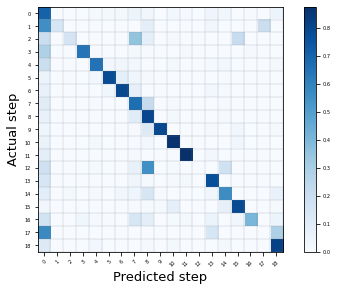

In [24]:
show_confusion_matrix('../test_results_pkl/LFB-resnet_test_7341.pkl','cm_M1.jpg')

num of labels  :  15425
num ori preds  :  15200
labels example :  0
preds example  :  tensor(0)
num of labels       :  15425
result of all preds  :  15425
Normalized confusion matrix
0.6635868277659323	0.0	0.00734423122482824	0.008528784648187633	0.02724472873726605	0.018005212035062782	0.013030087656953328	0.017531390665719022	0.018005212035062782	0.0	0.025112532575219143	0.02700781805259417	0.006633499170812604	0.0734423122482824	0.021321961620469083	0.014214641080312722	0.002606017531390666	0.0009476427386875149	0.05543710021321962
0.16666666666666666	0.0	0.0	0.08333333333333333	0.0	0.0	0.0	0.0	0.1388888888888889	0.0	0.0	0.2222222222222222	0.08333333333333333	0.19444444444444445	0.0	0.0	0.0	0.1111111111111111	0.0
0.1796875	0.0	0.484375	0.0	0.0625	0.0	0.0	0.0	0.0234375	0.0	0.0	0.0	0.0	0.078125	0.0078125	0.0625	0.0	0.0	0.1015625
0.3446601941747573	0.0	0.0048543689320388345	0.5436893203883495	0.01779935275080906	0.0	0.0	0.011326860841423949	0.008090614886731391	0.0	0.03398058252427184	

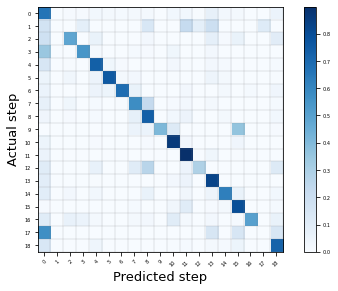

In [25]:
show_confusion_matrix('../test_results_pkl/LFB-densenet_test_7019.pkl','cm_M2.jpg')

num of labels  :  15425
num ori preds  :  15200
labels example :  0
preds example  :  tensor(0)
num of labels       :  15425
result of all preds  :  15425
Normalized confusion matrix
0.7692489931295902	0.0	0.00023691068467187872	0.0014214641080312722	0.016820658611703388	0.011845534233593935	0.010424070125562663	0.010424070125562663	0.00923951670220327	0.0	0.013030087656953328	0.007107320540156361	0.0	0.050935797204453924	0.011608623548922056	0.0045013030087656955	0.0	0.00023691068467187872	0.08291873963515754
0.4166666666666667	0.0	0.0	0.08333333333333333	0.027777777777777776	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.25	0.0	0.0	0.0	0.2222222222222222	0.0
0.078125	0.0	0.2734375	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0390625	0.0625	0.0234375	0.0	0.0	0.5234375
0.3446601941747573	0.0	0.0	0.5679611650485437	0.006472491909385114	0.003236245954692557	0.0	0.006472491909385114	0.006472491909385114	0.0	0.003236245954692557	0.0	0.0	0.024271844660194174	0.0	0.0	0.0016181229773462784	0.0016181229773462

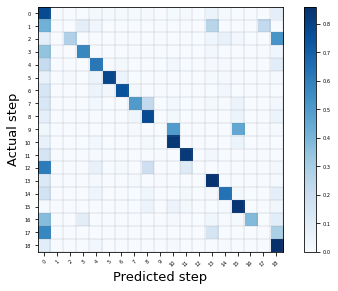

In [26]:
show_confusion_matrix('../test_results_pkl/LFB-resnest_test_7286.pkl','cm_M3.jpg')

num of labels  :  15425
num ori preds  :  15200
labels example :  0
preds example  :  tensor(0)
num of labels       :  15425
result of all preds  :  15425
Normalized confusion matrix
0.7671167969675432	0.0021321961620469083	0.002369106846718787	0.0011845534233593934	0.013740819710968964	0.013503909026297086	0.01089789149490642	0.027955460791281687	0.02179578298981284	0.00023691068467187872	0.016820658611703388	0.009950248756218905	0.00047382136934375743	0.0289031035299692	0.008528784648187633	0.0037905709547500594	0.0011845534233593934	0.00023691068467187872	0.06917791992418858
0.6111111111111112	0.027777777777777776	0.0	0.0	0.0	0.0	0.0	0.0	0.027777777777777776	0.0	0.0	0.027777777777777776	0.0	0.0	0.0	0.0	0.0	0.3055555555555556	0.0
0.4375	0.0	0.2265625	0.0	0.0	0.0	0.0	0.109375	0.0	0.0	0.0	0.0	0.0	0.0	0.0078125	0.140625	0.0	0.0	0.078125
0.34627831715210355	0.0	0.0	0.5954692556634305	0.0016181229773462784	0.0016181229773462784	0.0	0.01779935275080906	0.006472491909385114	0.0	0.0048543689

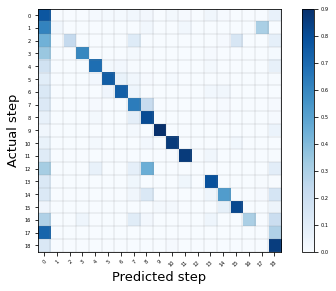

In [27]:
show_confusion_matrix('../test_results_pkl/NL-resnet_test_7468.pkl','cm_M4.jpg')

num of labels  :  15425
num ori preds  :  15200
labels example :  0
preds example  :  tensor(0)
num of labels       :  15425
result of all preds  :  15425
Normalized confusion matrix
0.648424543946932	0.0	0.005212035062781332	0.0028429282160625444	0.037668798862828715	0.022506515043828477	0.01468846244965648	0.03695806680881308	0.025823264629234777	0.0	0.007818052594171997	0.026533996683250415	0.011371712864250177	0.06467661691542288	0.01847903340440654	0.00734423122482824	0.0045013030087656955	0.002369106846718787	0.06278133143804786
0.3333333333333333	0.0	0.0	0.027777777777777776	0.0	0.0	0.0	0.0	0.1111111111111111	0.0	0.0	0.16666666666666666	0.0	0.3055555555555556	0.0	0.0	0.0	0.05555555555555555	0.0
0.1640625	0.0	0.5703125	0.0	0.078125	0.0	0.0	0.046875	0.015625	0.0	0.0	0.0	0.0	0.0546875	0.0	0.015625	0.0	0.0	0.0546875
0.313915857605178	0.0	0.0048543689320388345	0.5566343042071198	0.019417475728155338	0.014563106796116505	0.0	0.011326860841423949	0.008090614886731391	0.0	0.011326860841

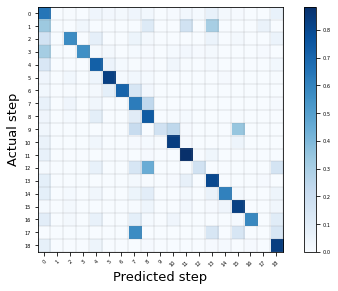

In [28]:
show_confusion_matrix('../test_results_pkl/NL-densenet_test_7123.pkl','cm_M5.jpg')

num of labels  :  15425
num ori preds  :  15200
labels example :  0
preds example  :  tensor(0)
num of labels       :  15425
result of all preds  :  15425
Normalized confusion matrix
0.806443970623075	0.0	0.0014214641080312722	0.0007107320540156361	0.007818052594171997	0.010187159440890783	0.012082444918265814	0.009002606017531391	0.0144515517649846	0.0	0.011371712864250177	0.02203269367448472	0.00047382136934375743	0.03245676380004738	0.013740819710968964	0.003316749585406302	0.0	0.0007107320540156361	0.05377872542051647
0.4722222222222222	0.0	0.0	0.05555555555555555	0.1111111111111111	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.08333333333333333	0.0	0.0	0.0	0.2777777777777778	0.0
0.078125	0.0	0.3125	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0078125	0.0	0.0	0.6015625
0.37702265372168287	0.0	0.0	0.5469255663430421	0.0016181229773462784	0.003236245954692557	0.0	0.0	0.006472491909385114	0.0	0.003236245954692557	0.0016181229773462784	0.0	0.0048543689320388345	0.0016181229773462784	0.0	0.0	0

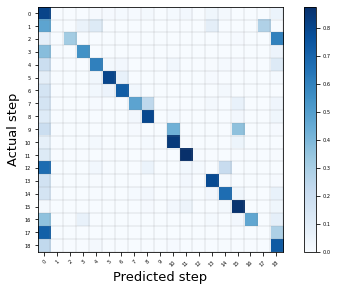

In [29]:
show_confusion_matrix('../test_results_pkl/NL-resnest_test_7349.pkl','cm_M6.jpg')

num of labels  :  15425
num ori preds  :  15200
labels example :  0
preds example  :  tensor(0)
num of labels       :  15425
result of all preds  :  15425
Normalized confusion matrix
0.7564558161573087	0.0037905709547500594	0.0035536602700781805	0.005922767116796968	0.013977730395640844	0.012082444918265814	0.008528784648187633	0.033641317223406776	0.011845534233593935	0.0011845534233593934	0.01610992655768775	0.007818052594171997	0.0037905709547500594	0.05306799336650083	0.012082444918265814	0.009476427386875147	0.004738213693437574	0.00023691068467187872	0.04169628050225065
0.4444444444444444	0.2777777777777778	0.0	0.05555555555555555	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.027777777777777776	0.0	0.027777777777777776	0.0	0.0	0.0	0.16666666666666666	0.0
0.375	0.0	0.265625	0.0	0.0	0.015625	0.0	0.2265625	0.0078125	0.0	0.0	0.0	0.0	0.0234375	0.0	0.0859375	0.0	0.0	0.0
0.3300970873786408	0.0	0.0	0.6084142394822006	0.003236245954692557	0.003236245954692557	0.0	0.0048543689320388345	0.0	0.0	0.006472491

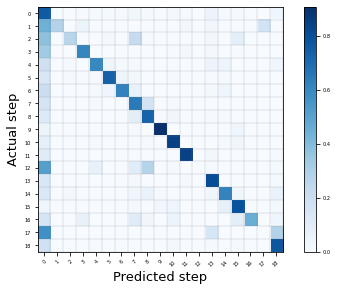

In [30]:
show_confusion_matrix('../test_results_pkl/NL-TVL-resnet_test_7290.pkl','cm_M7.jpg')

num of labels  :  15425
num ori preds  :  15200
labels example :  0
preds example  :  tensor(0)
num of labels       :  15425
result of all preds  :  15425
Normalized confusion matrix
0.6254442075337597	0.0	0.004738213693437574	0.008765695332859511	0.04548685145700071	0.016346837242359632	0.017294479981047144	0.016346837242359632	0.017768301350390904	0.0	0.030324567638000476	0.026060175313906656	0.010424070125562663	0.12082444918265814	0.012082444918265814	0.009950248756218905	0.008291873963515755	0.0011845534233593934	0.028666192845297322
0.16666666666666666	0.0	0.0	0.05555555555555555	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.027777777777777776	0.6388888888888888	0.0	0.0	0.0	0.1111111111111111	0.0
0.15625	0.0	0.5078125	0.0	0.0234375	0.0	0.0	0.0	0.0078125	0.0	0.0	0.0	0.0	0.2109375	0.0625	0.0	0.0	0.0	0.03125
0.3074433656957929	0.0	0.0	0.5889967637540453	0.011326860841423949	0.0016181229773462784	0.0	0.011326860841423949	0.006472491909385114	0.0	0.019417475728155338	0.021035598705501618	0.004854

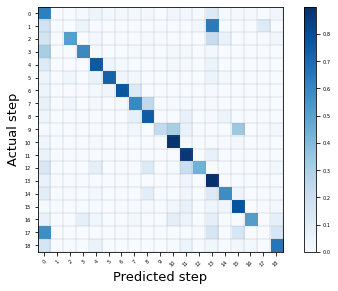

In [31]:
show_confusion_matrix('../test_results_pkl/NL-TVL-densenet_test_6935.pkl','cm_M8.jpg')

num of labels  :  15425
num ori preds  :  15200
labels example :  0
preds example  :  tensor(18)
num of labels       :  15425
result of all preds  :  15425
Normalized confusion matrix
0.7941246150201374	0.0	0.0018952854773750297	0.0009476427386875149	0.013266998341625208	0.01279317697228145	0.012556266287609572	0.014925373134328358	0.01279317697228145	0.0	0.005922767116796968	0.012319355602937692	0.0	0.03127221037668799	0.013030087656953328	0.003079838900734423	0.0	0.0007107320540156361	0.07036247334754797
0.3611111111111111	0.0	0.0	0.05555555555555555	0.027777777777777776	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.2777777777777778	0.0	0.0	0.0	0.25	0.027777777777777776
0.0625	0.0	0.3125	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.015625	0.0	0.0	0.0	0.609375
0.3640776699029126	0.0	0.0	0.5453074433656958	0.0016181229773462784	0.009708737864077669	0.0	0.0048543689320388345	0.006472491909385114	0.0	0.0048543689320388345	0.0	0.0	0.016181229773462782	0.0	0.0	0.0	0.0016181229773462784	0.045307443365

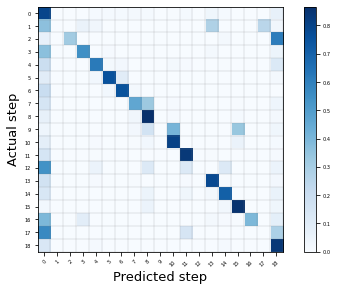

In [32]:
show_confusion_matrix('../test_results_pkl/NL-TVL-resnest_test_7360.pkl','cm_M9.jpg')